Step #100 A = [[ 0.01912046]
 [-1.2485381 ]] b = [[-0.6156551]]
Loss = [0.6749426]
Step #200 A = [[ 0.07131726]
 [-1.3777595 ]] b = [[-0.33842856]]
Loss = [0.67657775]
Step #300 A = [[ 0.18118832]
 [-1.4113334 ]] b = [[-0.18788458]]
Loss = [0.9652705]
Step #400 A = [[ 0.00309403]
 [-1.3892186 ]] b = [[-0.12917589]]
Loss = [0.55403817]
Step #500 A = [[ 0.01326016]
 [-1.3603599 ]] b = [[-0.10278469]]
Loss = [0.5554985]


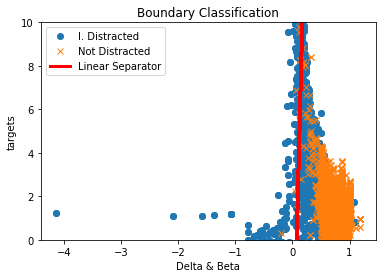

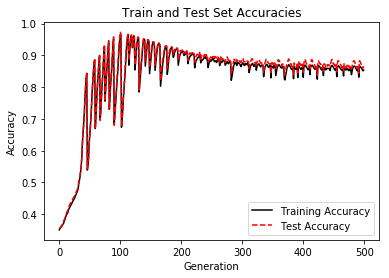

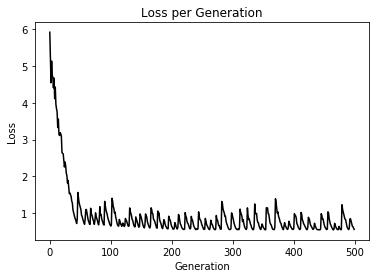

In [28]:
"""
Experimenting with support vector machines
"""
# Importing all the libraries 
import os
import json
import numpy                  as np
import tensorflow             as tf
import matplotlib.pyplot      as plt
from sklearn                  import svm

# These modules are used for the confusion matrix
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import confusion_matrix
from sklearn.utils.multiclass import unique_labels


class ClassifySVM:
    """
    data:   numpy array consisting of data consisting of float values.
    target: The target values associated with the input data.
    """
    
    # def ConfusionMatrix(self, data, target):   
    def SupportVectorClassify(self, data, target):

        # Spliting the datasets into training and testing portions
        sess          = tf.Session()
        train_indices = np.random.choice(len(data), round(len(data) * 0.8), replace=False)
        test_indices  = np.array(list(set(range(len(data))) - set(train_indices)))

        Beta_train    = data[train_indices]
        Beta_test     = data[test_indices]
        target_train  = target[train_indices]
        target_test   = target[test_indices]

        # Here we want a very large batch size to achieve convergence. 
        # The A variable will take on the 2 x 1 shape. (In the book, this is done because there are 2 predictor variables.)
        batch_size    = 25000
        x_data        = tf.placeholder(shape = [None, 2], dtype=tf.float32)
        y_target      = tf.placeholder(shape = [None, 1], dtype=tf.float32)
        A = tf.Variable(tf.random_normal(shape=[2,1]))
        b = tf.Variable(tf.random_normal(shape=[1,1]))

        # For correctly classified points, values of >= 1 if target is 1.
        model_output = tf.subtract(tf.matmul(x_data, A), b)

        # Calculate the L2 normm of a vector. 
        # Margin parameter: a
        l2_norm      = tf.reduce_sum(tf.square(A))
        alpha        = tf.constant([0.1])

        # Declaring classification loss and adding together the two terms.
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_target))))
        loss                = tf.add(classification_term, tf.multiply(alpha, l2_norm))

        # Declaring the prediction and accuracy functions to evaluate bot the training and test sets.
        prediction = tf.sign(model_output)
        accuracy   = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

        # Declaring optimization function and initializing model variables.
        my_opt     = tf.train.GradientDescentOptimizer(0.01)
        train_step = my_opt.minimize(loss)
        init       = tf.global_variables_initializer()
        sess.run(init)

        # Starting the training loop. 
        # Making sure to record loss and training accuracy for both training and test sets. 
        loss_vec = []
        train_accuracy = []
        test_accuracy  = []
        
        test_record = {}

        for i in range(500):
            rand_index = np.random.choice(len(Beta_train), size=batch_size)
            
            rand_x     = Beta_train[rand_index]
            rand_y     = np.transpose([target_train[rand_index]])
            no_end     = sess.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
            
            # Storing the loss from each iteration into loss_vec
            temp_loss  = sess.run(loss, feed_dict = {x_data:rand_x, y_target:rand_y})
            loss_vec.append(temp_loss)

            # Storing train accuracies for each iteration of classification
            train_acc_temp = sess.run(accuracy, feed_dict={x_data:Beta_train, y_target:np.transpose([target_train])})
            train_accuracy.append(train_acc_temp)

            # Storing test accuracies for each iteration of classification
            test_acc_temp = sess.run(accuracy, feed_dict={x_data:Beta_test, y_target:np.transpose([target_test])})
            test_accuracy.append(test_acc_temp)
            
            test_record[str(test_acc_temp)] = [Beta_test.tolist(), target_test.tolist()]
            
            if (i+1)%100 == 0:
                print('Step #' + str(i + 1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
                print('Loss = ' + str(temp_loss))
                
        with open("/Users/" + os.getlogin() + "/Desktop/SVMData.json", "w") as repository:
            json.dump(test_record, repository, sort_keys=True, indent=4)
        repository.close()

        # Plotting the outputs (fit, loss and accuracy), the coefficients.
        [[a1], [a2]] = sess.run(A)
        [[b]]        = sess.run(b)
        slope        = -a2/a1
        y_intercept  = b/a1
        x1_vals      = [d[1] for d in data]

        best_fit     = []
        for i in x1_vals:
            best_fit.append(slope*i+y_intercept)

        feature_x     = [d[1] for i,d in enumerate(data) if target[i] == 1]
        feature_y     = [d[0] for i,d in enumerate(data) if target[i] == 1]
        not_feature_x = [d[1] for i,d in enumerate(data) if target[i] == -1]
        not_feature_y = [d[0] for i,d in enumerate(data) if target[i] == -1]

        plt.plot(feature_x, feature_y, 'o', label='I. Distracted')
        plt.plot(not_feature_x, not_feature_y, 'x', label='Not Distracted')
        plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
        plt.ylim([0, 10])
        plt.legend(loc='upper left')
        plt.title('Boundary Classification')
        plt.xlabel('Delta & Beta')
        plt.ylabel('targets')
        plt.show()

        plt.plot(train_accuracy, 'k-', label='Training Accuracy')
        plt.plot(test_accuracy, 'r--', label='Test Accuracy')
        plt.title('Train and Test Set Accuracies')
        plt.xlabel('Generation')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        plt.plot(loss_vec, 'k-')
        plt.title('Loss per Generation')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()

# Reading from the csv file.
path = r'/Users/KaushikBhimraj/Desktop/Merged1_Data.csv'

# List comprehension used to create numpy arrays for inputs and targets.
# Removing the heading row and converting the string values to int.  
I           = [[line.split(',')[0], line.split(',')[1]] for line in open(path) if line[0:1] != '\n'][1:]
BetaDelta   = np.array([[float(val[0]), float(val[1])] for val in I])
Target      = np.array([line.split(',')[2] for line in open(path) if line[0:1] != '\n'][1:])

# Converting target to -1 or 1 format.
T           = np.array([float(1) if y == "Distracted\n" else float(-1) for y in Target])

# Calling the class object and the function inside it that will execute the suport vector algorithm.
c = ClassifySVM()
c.SupportVectorClassify(BetaDelta, T)
